# Is a 4-d boolean function sepereable ?

In [2]:
import numpy as np

In [245]:
from tqdm import tqdm

In [248]:
import matplotlib.pyplot as plt

## load the data for the function

In [8]:
data = np.genfromtxt('data/input_data_numeric.csv', delimiter=',')

In [14]:
data.shape

(16, 5)

In [75]:
inputs = data[:,1:5].T

In [76]:
test_output = np.array( [1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1] )

## define the perceptron structure

In [77]:
class Perceptron:
    
    def __init__(self,number_of_input,activation_function,derivate_activation_function,weight=None,bias=None,random_weight=True,weight_range=0.2,bias_range=1):
        
        self.n = number_of_input
        self.activation_function = activation_function
        self.derivate_activation_function = derivate_activation_function
        
        if (weight==None):
            if random_weight:
                self.w = weight_range*(2*np.random.rand(self.n) - 1)
            else:
                self.w = np.zeros(self.n)
        
        else:
            if not(weight.shape== (self.n,)):
                raise ValueError(f"weight param should be of shape ({self.n},) but it is {weight.shape}")
            else:
                self.w = weight
        
        if (bias==None):
            if random_weight:
                self.b= bias_range*(2*np.random.rand()-1)
            else:
                self.b = 0
        
        else:
            self.b = bias
    
    
    def activate(self,x):        
        return self.activation_function(self.w.T@x + self.b)
    
    def derivate(self,x):
        return self.derivate_activation_function(self.w.T@x + self.b)


In [78]:
activation_func = lambda x : np.tanh(x/2)

In [79]:
derivate_activation_func = lambda x :  (1-np.tanh(x/2)**2)/2

## Define energy func and grad

In [398]:
neuron = Perceptron(inputs.shape[0],activation_func,derivate_activation_func)

In [399]:
neuron.activate(inputs[:,0])

0.511569063202566

In [400]:
neuron.derivate(inputs[:,0])

0.3691485467870245

In [401]:
def energy_func(p,inputs,real_value):
    return (((p.activate(inputs)-real_value)**2)/2).mean()

def grad_enery(p,inputs,real_value):
    
    grad_w = 2*((p.activate(inputs)-real_value)/2)*inputs*p.derivate(inputs)
    
    grad_b = 2*((p.activate(inputs)-real_value)/2)*p.derivate(inputs)
    
    if len(grad_w.shape) > 1:
        return np.concatenate((grad_w,np.expand_dims(grad_b,axis=0))).mean(axis=1)
    else:
        return np.concatenate((grad_w,np.expand_dims(grad_b,axis=0)))

In [402]:
energy_func(neuron,inputs,test_output)

0.3550260734851924

In [403]:
grad_enery(neuron,inputs[:,0],test_output[0])

array([ 0.18030357,  0.18030357,  0.18030357,  0.18030357, -0.18030357])

In [404]:
grad_enery(neuron,inputs,test_output).shape

(5,)

## train the weights

In [415]:
def check_for_linear_separability(inputs,outputs,nb_epoch,lr,method="grad",plot=True):
    
    neuron = Perceptron(inputs.shape[0],activation_func,derivate_activation_func)
    energies = np.zeros(nb_epoch)
    
    for i in tqdm(range(nb_epoch)):


        #inputs_method = inputs # gradient descent
        
        if method == "grad":
            inputs_method = inputs
            outputs_method = outputs
        
        elif method == "sequential":
            index = i%inputs.shape[1]
            inputs_method = inputs[:,index]
            outputs_method = outputs[index]
            
        elif method == "sto":
            index = np.random.randint(inputs.shape[1])
            inputs_method = inputs[:,index]
            outputs_method = outputs[index]
        
        else:
            raise ValueError(f"{method} is not a method")
            
        energies[i] =energy_func(neuron,inputs_method,outputs_method)

        grad = grad_enery(neuron,inputs_method,outputs_method)

        grad_b = grad[-1]
        grad_w = grad[0:-1]

        neuron.w = neuron.w - lr*grad_w
        neuron.b = neuron.b - lr*grad_b

    
    if plot:
        plt.plot(energies)
        print(energies[-1])
    
    return (np.sign(neuron.activate(inputs)) == outputs).all()

## test on functions

In [416]:
nb_epoch=int(1e3)
lr = 0.02

In [417]:
output = np.array( [1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1] )

100%|██████████| 1000/1000 [00:00<00:00, 13264.72it/s]

9.689323314689867e-06


True

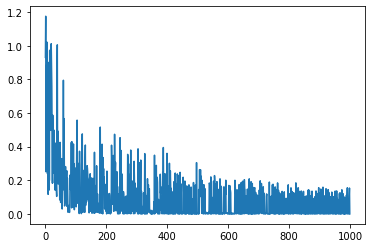

In [418]:
check_for_linear_separability(inputs,test_output,nb_epoch,lr=lr*inputs.shape[0],method="sto")

100%|██████████| 1000/1000 [00:00<00:00, 10311.22it/s]

0.10401284604111236


True

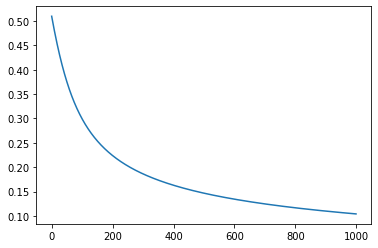

In [419]:
check_for_linear_separability(inputs,test_output,nb_epoch,lr,method="grad")

100%|██████████| 1000/1000 [00:00<00:00, 17385.93it/s]

0.0926175526874759


True

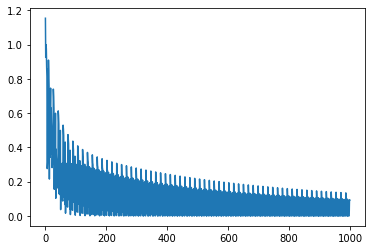

In [421]:
check_for_linear_separability(inputs,test_output,nb_epoch,lr=lr*inputs.shape[0],method="sequential")